In [ ]:
import os
import sys
sys.path.append(os.path.abspath('/Residual_Embedding/code'))
import utils
from utils import get_word_level_embedding
sys.path.append(os.path.abspath('/LLM_Probing/code'))
from model_loader import ModelLoader
from residual_reasoning import ResidualReasoningConstructor
import pandas as pd
import numpy as np
import pickle
import joblib

In [ ]:
cache_dir = 'your_hf_cache_dif'
hf_token = 'your_hf_token'
use_gpu = True

model_name = "Qwen/Qwen2.5-14B"
loader = ModelLoader(
    model_name=model_name,
    cache_dir=cache_dir,
    hf_token=hf_token,
    use_gpu=use_gpu,
    speech_mode=False,
    baseline_mode=False,
)
   
model, tokenizer = loader.load()

## 16 Podcast Episodes

### extract hidden states

In [ ]:
df = pd.read_csv("/Data/lines_clean.csv")
df = df[(df["episode_id"] >= 616) & (df["episode_id"] <= 631)]
df = df[df["act_name"].str.startswith('Act')]
corpus = " ".join(df["line_text"].astype(str))
len(tokenizer(corpus)["input_ids"])

In [ ]:
source_target_layers = [(0, 6), (6, 20), (20, 30)]
context_size = 50
constructor = ResidualReasoningConstructor(
    tokenizer=tokenizer,
    model=model,
    source_target_layers=source_target_layers,
    context_size=context_size,
    device="cuda",
)

hidden = constructor._extract_hidden_states(corpus)
with open(f"/Data/this_american_life_{model_name.split('/')[-1]}.pkl", "wb") as f:
    pickle.dump(hidden, f)

### train residual ridge

In [ ]:
dataset_name = "this_american_life"
residuals_path = f"/Data/monkey_story_{model_name.split('/')[-1]}/"
log_path = residuals_path
context_size = 50

constructor = ResidualReasoningConstructor(
    tokenizer=tokenizer,
    model=model,
    source_target_layers=source_target_layers,
    context_size=context_size,
    param_grid={"alpha": [1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3]},
    cv_splits=4,
    device="cuda",
    log_path=log_path
)
hidden_pair_list = constructor._fit(corpus=None, hidden=hidden, no_scale=True, return_hidden_pair_list=False)

for i, (source_layer, target_layer) in enumerate(constructor.source_target_layers):
    joblib.dump(constructor.ridge_models[i], f"/Data/pretrained_ridge_models/{dataset_name}_{source_layer}_{target_layer}_{model_name.split('/')[-1]}.joblib")

## Episode of Monkey Story

In [ ]:
from utils import get_words_from_bpe_tokens

df = pd.read_csv("/Residual_Embedding/code/data/podcast_transcript.csv")
corpus = " ".join(df["word"].astype(str))
dataset_name = "monkey_story"
constructor.pretrained_ridge_models = constructor.ridge_models

In [ ]:
df_list = get_word_level_embedding(constructor, corpus)

for df, (source_layer, target_layer) in zip(df_list, source_target_layers):
    df.to_pickle(f"{residuals_path}{dataset_name}_{model_name.split('/')[-1]}_{context_size}_{source_layer}_{target_layer}.pkl")

### Mean Absolute Cosine Similarity

/tmp/ipykernel_56962/3908044290.py:13: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  df = pickle.load(file)
/tmp/ipykernel_56962/3908044290.py:13: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, 

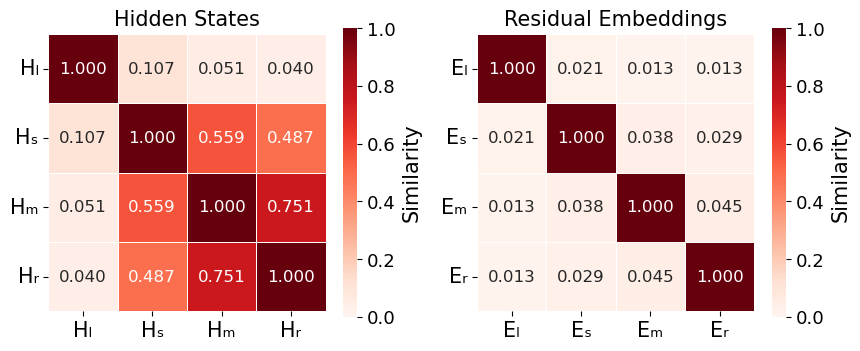

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

context_size = 50
residual_list = []
hidden_list = []
layers = []

for source_layer, target_layer in source_target_layers:
    with open(f"{residuals_path}{dataset_name}_{model_name.split('/')[-1]}_{context_size}_{source_layer}_{target_layer}.pkl", "rb") as file:
        df = pickle.load(file)

        if source_layer == 0:
            layer_0 = np.vstack(df["layer_0"].to_numpy())
            hidden_list.append(layer_0)
            residual_list.append(layer_0)

        hidden = np.vstack(df[f"layer_{target_layer}"].to_numpy())
        hidden_list.append(hidden)
        residual = np.vstack(df["residual"].to_numpy())
        residual_list.append(residual)
        layers.append(target_layer)

fig, axes = plt.subplots(1, 2, figsize=(8.75, 3.5))

for i, some_list in enumerate([hidden_list, residual_list]):
    n = some_list[0].shape[0]
    abs_cos_sum = np.zeros((4, 4))

    for j in range(n):
        sample_vectors = [residual[j] for residual in some_list]
        stacked = np.stack(sample_vectors)

        cos_sim = cosine_similarity(sample_vectors)
        abs_cos_sim = np.abs(cos_sim)
        abs_cos_sum += abs_cos_sim

    mean_abs_cos_sim = abs_cos_sum / n

    if some_list is hidden_list:
        labels = ["Hₗ", "Hₛ", "Hₘ", "Hᵣ"]
        sub_title = "Hidden States"
    else:
        labels = ["Eₗ", "Eₛ", "Eₘ", "Eᵣ"]
        sub_title = "Residual Embeddings"

    sns.heatmap(
        mean_abs_cos_sim, ax=axes[i],
        annot=True, fmt=".3f",
        vmin=0, vmax=1,
        xticklabels=labels,
        yticklabels=labels,
        cmap="Reds", square=True,
        linewidths=0.5,
        annot_kws={"fontsize": 12}
    )
    cbar = axes[i].collections[0].colorbar
    cbar.ax.tick_params(labelsize=13)
    cbar.ax.set_ylabel("Similarity", fontsize=15)
    axes[i].set_title(sub_title, fontsize=15)
    axes[i].tick_params(axis='x', labelsize=15)
    axes[i].tick_params(axis='y', labelsize=15, labelrotation=0)

plt.tight_layout()
plt.show()

## BLiMP Dataset

### Extract hidden states

In [ ]:
def _find_files(folder_path, endswith='.csv'):
    found_files = []
    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.endswith(endswith):
                found_files.append(os.path.join(root, file))
    return found_files

In [ ]:
data_path = '/LLM_Probing/data/BLiMP/'
jsonl_files = _find_files(data_path, endswith='.jsonl')
task_num = len(jsonl_files)
print("Number of BLiMP files:", task_num)

sentences = []
for file_id in range(task_num):
    file_path = jsonl_files[file_id]
    df = pd.read_json(file_path, lines=True)

    sentences.extend(df['sentence_good'].tolist() + df['sentence_bad'].tolist())

dataset_name = "BLiMP"
residuals_path = f"/Data/{dataset_name}_{model_name.split('/')[-1]}/"
log_path = residuals_path

In [ ]:
source_target_layers = [(0, 6), (6, 20), (20, 30)]
context_size = -1
constructor = ResidualReasoningConstructor(
    tokenizer=tokenizer,
    model=model,
    source_target_layers=source_target_layers,
    context_size=context_size,
    param_grid={"alpha": [1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3]},
    cv_splits=4,
    device="cuda",
    log_path=log_path
)

hidden = constructor._extract_hidden_states(sentences, average_layer_0=True)
with open(f"/Data/{dataset_name}/blimp_hidden.pkl", "wb") as f:
    pickle.dump(hidden, f)

### Train ridge for residual

In [ ]:
bow_results = pd.read_csv('/LLM_Probing/results/blimp/blimp_base_bow_-1_bow.csv')

is_good_task = []
for file_id in range(task_num):
    file_path = jsonl_files[file_id]
    df = pd.read_json(file_path, lines=True)
    type_name = df["UID"][0]

    bow_f1 = bow_results[bow_results['tse_type'] == type_name]['f1'].values[0]
    current_sentences_len = len(df['sentence_good'].tolist() + df['sentence_bad'].tolist())

    if not bow_f1 > 0.6:
        is_good_task.extend([True] * current_sentences_len)
    else:
        is_good_task.extend([False] * current_sentences_len)

In [ ]:
hidden_pair_list = constructor._fit(corpus=None, hidden=hidden, no_scale=True, return_hidden_pair_list=True)

for i, (source_layer, target_layer) in enumerate(constructor.source_target_layers):
    joblib.dump(constructor.ridge_models[i], f'/Data/pretrained_ridge_models/{dataset_name}_{source_layer}_{target_layer}_{model_name.split('/')[-1]}.joblib')

### BLiMP Residuals

In [ ]:
residual_list = []

for ridge_index, (source_hidden_scaled, target_hidden) in enumerate(hidden_pair_list):
    residual = constructor._compute_residuals(source_hidden_scaled, target_hidden, ridge_index)
    residual_list.append(residual)

df_list = []
for residual_index, (source_layer, target_layer) in enumerate(source_target_layers):
    residuals = residual_list[residual_index]
    data = []

    for i in range(residuals.shape[0]):
        res = residuals[i]

        data.append({
            f"BLiMP_id": i,
            "residual": res
        })

    df = pd.DataFrame(data)
    df_list.append(df)

for df, (source_layer, target_layer) in zip(df_list, source_target_layers):
    df.to_pickle(f"{residuals_path}{dataset_name}_{model_name.split('/')[-1]}_{context_size}_{source_layer}_{target_layer}.pkl")

## COMPS Dataset

### Extract Hidden States

In [ ]:
dataset_name = "comps_base"
# dataset_name = "comps_wugs_dist"
context_size = -1
residuals_path = f"/Data/COMPS_{model_name.split('/')[-1]}/"
log_path = residuals_path

dataset = pd.read_json(f"/LLM_Probing/data/COMPS/{dataset_name}.jsonl", lines=True)
acceptable_sentences = dataset["prefix_acceptable"] + " " + dataset["property_phrase"]
unacceptable_sentences = dataset["prefix_unacceptable"] + " " + dataset["property_phrase"]
sentences = pd.concat([acceptable_sentences, unacceptable_sentences], ignore_index=True)

In [ ]:
source_target_layers = [(0, 6), (6, 20), (20, 30)]
context_size = -1
constructor = ResidualReasoningConstructor(
    tokenizer=tokenizer,
    model=model,
    source_target_layers=source_target_layers,
    context_size=context_size,
    param_grid={"alpha": [1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3]},
    cv_splits=4,
    device="cuda",
    log_path=log_path
)

hidden = constructor._extract_hidden_states(sentences, average_layer_0=True)
with open(f"/Data/COMPS/{dataset_name}_hidden.pkl", "wb") as f:
    pickle.dump(hidden, f)

### train ridge for residual

In [52]:
hidden_pair_list = constructor._fit(corpus=None, hidden=hidden, no_scale=True)

for i, (source_layer, target_layer) in enumerate(constructor.source_target_layers):
    joblib.dump(constructor.ridge_models[i], f'/Data/pretrained_ridge_models/{dataset_name}_{source_layer}_{target_layer}.joblib')

### COMPS Residuals

In [53]:
residual_list = []

for ridge_index, (source_hidden_scaled, target_hidden) in enumerate(hidden_pair_list):
    residual = constructor._compute_residuals(source_hidden_scaled, target_hidden, ridge_index)
    residual_list.append(residual)

df_list = []
for residual_index, (source_layer, target_layer) in enumerate(source_target_layers):
    residuals = residual_list[residual_index]
    data = []

    for i in range(residuals.shape[0]):
        res = residuals[i]

        data.append({
            f"{dataset_name}_id": i,
            "residual": res
        })

    df = pd.DataFrame(data)
    df_list.append(df)

for df, (source_layer, target_layer) in zip(df_list, source_target_layers):
    df.to_pickle(f"{residuals_path}{dataset_name}_{model_name.split('/')[-1]}_{context_size}_{source_layer}_{target_layer}.pkl")

## Feature Probing Plots

In [68]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

In [ ]:
blimp_residual_results = pd.read_csv(f'/LLM_Probing/results/blimp/blimp_base_qwen_14B_-1_no_scale.csv')
base_residual_results = pd.read_csv(f'/LLM_Probing/results/comps/comps_base_qwen_14B_-1_no_scale.csv')
wugs_residual_results = pd.read_csv(f'/LLM_Probing/results/comps/comps_wugs_dist_qwen_14B_-1_no_scale.csv')

base_residual_results = base_residual_results[base_residual_results["linguisitics_form"] != "random"]
wugs_residual_results = wugs_residual_results[wugs_residual_results["linguisitics_form"] != "random"]

blimp_residual_acc = blimp_residual_results.groupby("gpt_layer")["accuracy"].mean()
base_residual_acc = base_residual_results.groupby("gpt_layer")["accuracy"].mean()
wugs_residual_acc = wugs_residual_results.groupby("gpt_layer")["accuracy"].mean()

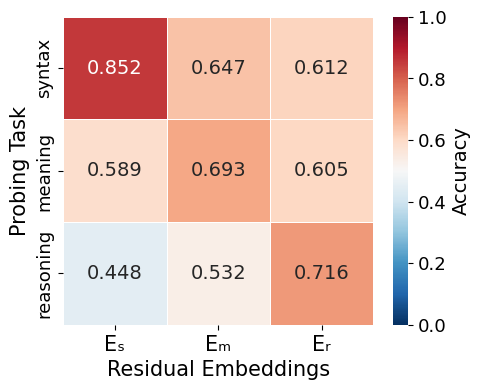

In [61]:
residual_data = np.array([
    blimp_residual_acc,
    base_residual_acc,
    wugs_residual_acc
])

df = pd.DataFrame(residual_data,
    index=["syntax", "meaning", "reasoning"],
    columns=["Eₛ", "Eₘ", "Eᵣ"]
)

plt.figure(figsize=(5, 4))

ax = sns.heatmap(
    df,
    cmap="RdBu_r",        # Diverging colormap
    vmin=0.0, vmax=1.0,   # Range 0–1
    center=0.5,           # Midpoint (divergence center)
    annot=True, fmt=".3f",
    linewidths=0.5,
    cbar_kws={"label": "Residual Accuracy"},
    annot_kws={"fontsize": 14}
)

# Axis and colorbar formatting
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=13)

cbar = ax.collections[0].colorbar
cbar.ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))
cbar.ax.tick_params(labelsize=13)
cbar.ax.set_ylabel("Accuracy", fontsize=14)

plt.xlabel("Residual Embeddings", fontsize=15)
plt.ylabel("Probing Task", fontsize=15)

plt.show()


In [63]:
max_scores = [0, 0, 0]
layer_num = 48

blimp_results = pd.read_csv(f"{temp}/LLM_Probing/results/blimp/blimp_base_qwen_14B_500_filter_all.csv")
base_results = pd.read_csv(f"{temp}/LLM_Probing/results/comps/comps_base_qwen_14B_-1.csv")
wugs_results = pd.read_csv(f"{temp}/LLM_Probing/results/comps/comps_wugs_dist_qwen_14B_-1.csv")

base_results = base_results[base_results["linguisitics_form"] != "random"]
wugs_results = wugs_results[wugs_results["linguisitics_form"] != "random"]

for i, result in enumerate([
    blimp_results, base_results, wugs_results
]):
    for layer in range(layer_num):
        layer_scores = result[result['gpt_layer'] == layer]
        layer_mean = layer_scores["accuracy"].mean()
        if layer_mean > max_scores[i]:
            max_scores[i] = layer_mean

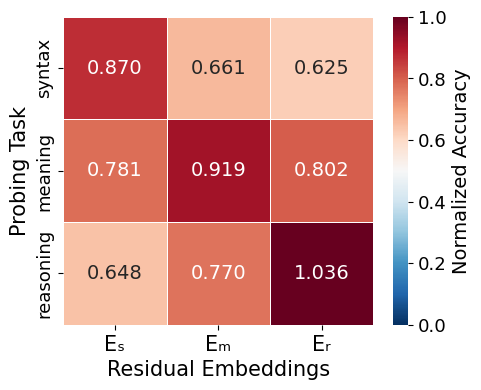

In [65]:
residual_data = np.array([
    blimp_residual_acc / max_scores[0],
    base_residual_acc / max_scores[1],
    wugs_residual_acc / max_scores[2]
])

df = pd.DataFrame(residual_data, index=["syntax", "meaning", "reasoning"], columns=["Eₛ", "Eₘ", "Eᵣ"])

plt.figure(figsize=(5, 4))

ax = sns.heatmap(
    df,
    cmap="RdBu_r",        # Diverging colormap
    vmin=0.0, vmax=1.0,   # Range 0–1
    center=0.5,           # 👈 Midpoint (divergence center)
    annot=True,
    fmt=".3f",
    linewidths=0.5,
    # cbar_kws={"label": "Hidden States Accuracy / Baseline Accuracy"},
    annot_kws={"fontsize": 14}
)

ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=13)

colorbar = ax.collections[0].colorbar
colorbar.ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))  # Ensure matching format
colorbar.ax.tick_params(labelsize=13)        # Tick labels of colorbar
colorbar.ax.set_ylabel("Normalized Accuracy", fontsize=14)  # Colorbar label font

# plt.title(f"Residual Embeddings", fontsize=15)
plt.xlabel("Residual Embeddings", fontsize=15)
plt.ylabel("Probing Task", fontsize=15)

plt.show()

In [66]:
scores = [[0, 0, 0], [0, 0, 0], [0, 0, 0]]
layer_num = 48

for i, result in enumerate([
    blimp_results, base_results, wugs_results
]):
    for j, layer in enumerate([6, 20, 30]):
        layer_scores = result[result['gpt_layer'] == layer]
        layer_mean = layer_scores["accuracy"].mean()
        scores[i][j] = layer_mean

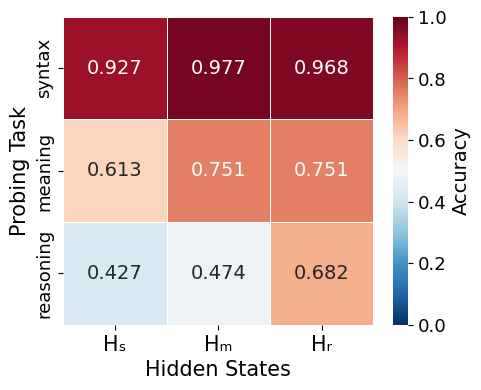

In [67]:
df = pd.DataFrame(scores, index=["syntax", "meaning", "reasoning"], columns=["Hₛ", "Hₘ", "Hᵣ"])

plt.figure(figsize=(5, 4))

ax = sns.heatmap(
    df,
    cmap="RdBu_r",        # Diverging colormap
    vmin=0.0, vmax=1.0,   # Range 0–1
    center=0.5,           # Midpoint (divergence center)
    annot=True,
    fmt=".3f",
    linewidths=0.5,
    cbar_kws={"label": "Hidden States Accuracy"},
    annot_kws={"fontsize": 14}
)

ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=13)

colorbar = ax.collections[0].colorbar
colorbar.ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))  # Ensure matching format
colorbar.ax.tick_params(labelsize=13)        # Tick labels of colorbar
colorbar.ax.set_ylabel("Accuracy", fontsize=14)  # Colorbar label font

# plt.title(f"Hidden States", fontsize=15)
plt.xlabel("Hidden States", fontsize=15)
plt.ylabel("Probing Task", fontsize=15)

plt.show()

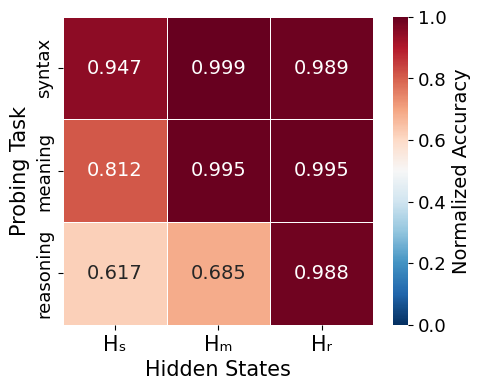

In [70]:
df = pd.DataFrame(
    np.array([
        pd.Series(scores[0]) / max_scores[0],
        pd.Series(scores[1]) / max_scores[1],
        pd.Series(scores[2]) / max_scores[2]
    ]), 
    index=["syntax", "meaning", "reasoning"], columns=["Hₛ", "Hₘ", "Hᵣ"]
)

plt.figure(figsize=(5, 4))

ax = sns.heatmap(
    df,
    cmap="RdBu_r",        # Diverging colormap
    vmin=0.0, vmax=1.0,   # Range 0–1
    center=0.5,           # Midpoint (divergence center)
    annot=True,
    fmt=".3f",
    linewidths=0.5,
    annot_kws={"fontsize": 14}
)

ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=13)

colorbar = ax.collections[0].colorbar
colorbar.ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))  # Ensure matching format
colorbar.ax.tick_params(labelsize=13)        # Tick labels of colorbar
colorbar.ax.set_ylabel("Normalized Accuracy", fontsize=14)  # Colorbar label font

# plt.title(f"Hidden States", fontsize=15)
plt.xlabel("Hidden States", fontsize=15)
plt.ylabel("Probing Task", fontsize=15)
plt.show()